code to derive from virga data the following:
- T/MR profiles in virga conditions, aggregated as a function of virga depth
- Horizontal wind speed in virga conditions, aggregated as a function od virga depth


In [2]:
#import allLibraries
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import rcParams
from warnings import warn
import datetime as dt
from scipy import interpolate
import custom_color_palette as ccp
import matplotlib as mpl 
import os.path
import itertools    
import os.path
from arthus_functions_bearbeitet import *

TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [14]:
#open datasets and merge the, to have all information in one big dataset

var = 'T_anomaly'
#var = 'MR_anomaly'
#var = 'VW_anomaly'

measurement = 'T'
#measurement = 'MR'
#measurement = 'VW'


# read arthus_data specifying the variable of interest ('T','MR','VW','LHF','SHF') to get the dates_list
# dataset arthus is not needed from here, because we also need the anomaly values, that are in different file
if (measurement == 'T' or var == 'T'):
    dataset_arthus, dates_list = f_read_merian_data("ARTHUS","T")
elif (measurement == 'MR' or var == 'MR'):
    dataset_arthus, dates_list = f_read_merian_data("ARTHUS","MR")
elif (measurement == 'VW' or var == 'VW'):    
    dataset_arthus, dates_list = f_read_merian_data("ARTHUS","VW")   

#reading dataset arthus anomaly   
dataset_arthus_anomaly = xr.open_dataset('/net/ostro/4sibylle/diurnal_cycle_arthus/anomalies_fields/'+measurement + '_arthus_anomaly.nc')    

# reading corresponding wband
wband_list = []
path_wband = '/data/obs/campaigns/eurec4a/msm/wband_radar/ncdf/published_data_v2/'
for ind_list in range(len(dates_list)):  
    wband_list.append(path_wband+dates_list[ind_list]+'_wband_radar_msm_eurec4a_intake.nc')    
# reading all mrr data in one
wband_data = xr.open_mfdataset(wband_list,  combine='nested', concat_dim='time')
        
# reading cloud properties's files form Claudia and Nils
cloud_properties = xr.open_dataset('cloud_class_prop_flags.nc') 

# interpolate classification on mrr_data time resolution
class_interp = cloud_properties.interp(time=dataset_arthus_anomaly.time.values, method='nearest')
wband_interp = wband_data.interp(time=dataset_arthus_anomaly.time.values, method='nearest')
wband_interp_h = wband_interp.interp(height=dataset_arthus_anomaly.height.values, method='nearest')


merian_dataset = xr.merge([class_interp, dataset_arthus_anomaly, wband_interp_h])  


T
var_str T
{'var_name': 'T', 'var_string': 'Temperature', 'var_units': ' $^{\\circ}$K', 'var_min': 290.0, 'var_max': 310.0, 'thr_min': 280.0, 'thr_max': 330.0, 'avg_time': '15', 'cmap': 'jet', 'title': 'Air temperature: 28/01-04/02'}
T
arthusfile ist: ['/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200123_010914-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200124_005950-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200125_000001-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200126_000000-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200127_000004-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200128_000005-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200129_000009-13000_243000_T_gr_10s_50m.cdf'
 '/data/obs/campaigns/eurec4a/msm/arthus_dl/T/20200130_000003-13000_243000_T_gr_10s_50m.cdf'
 '/

### Rain rate ###

In [15]:
# selecting rain data
ind_rain = np.where((merian_dataset.flag_rain.values == 1))[0]
data_rain = merian_dataset.isel(time=ind_rain)

# selecting rain reaching the ground
ind_rain_ground = np.where(data_rain.flag_rain_ground.values == 1)[0]
data_rain_ground = data_rain.isel(time=ind_rain_ground)

# segregating with respect to shallow and deep clouds
ind_shallow = np.where((data_rain_ground.shape.values == 0))[0]
ind_deep = np.where((data_rain_ground.shape.values == 1))[0]
data_rain_g_shallow = data_rain_ground.isel(time=ind_shallow)
data_rain_g_deep = data_rain_ground.isel(time=ind_deep)

### Virga depth ###

In [16]:
# selecting rain data
ind_rain = np.where((merian_dataset.flag_rain.values == 1))[0]
data_rain = merian_dataset.isel(time=ind_rain)

# selecting rain not reaching the ground
ind_virga = np.where(data_rain.flag_rain_ground.values == 0)[0]
data_virga = data_rain.isel(time=ind_virga)

# segregating with respect to shallow and deep clouds
ind_shallow = np.where((data_virga.shape.values == 0))[0]
ind_deep = np.where((data_virga.shape.values == 1))[0]
data_virga_shallow = data_virga.isel(time=ind_shallow)
data_virga_deep = data_virga.isel(time=ind_deep)

### Methode 1 mit numpy ### 
y-achse ist um faktor 100 kleiner
nächste schritte: rain rate plotten (bisher nur virga_depth erfolgreich)

In [17]:
#set all zero values to nan so it does not appear in the histogram
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

#virga depth
shallow_vd_data = zero_to_nan(data_virga_shallow.virga_depth.values)
deep_vd_data = zero_to_nan(data_virga_deep.virga_depth.values)

#rain_rate
shallow_rr_data = zero_to_nan(data_rain_g_shallow.rain_rate.values)
deep_rr_data = zero_to_nan(data_rain_g_deep.rain_rate.values)



In [18]:
#virga depth
hist_vd_s, bins_vd_s = np.histogram(shallow_vd_data, bins=9, range=(0., 1000.), density=True)
hist_vd_d, bins_vd_d = np.histogram(deep_vd_data, bins=9, range=(0., 1000.), density=True)
hist_vd_s = hist_vd_s / hist_vd_s.sum()
hist_vd_d = hist_vd_d / hist_vd_d.sum()
#print(shallow_vd_data)
#print(hist_vd_s, bins_s)

#rain rate
hist_rr_s, bins_rr_s = np.histogram(shallow_rr_data, bins=9, range=(0., 35.), density=True)
hist_rr_d, bins_rr_d = np.histogram(deep_rr_data, bins=9, range=(0., 35.), density=True)
hist_rr_s = hist_rr_s / hist_rr_s.sum()
hist_rr_d = hist_rr_d / hist_rr_d.sum()
#print(hist_rr_s, bins_rr_s)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma


FileNotFoundError: [Errno 2] No such file or directory: '/work/plots_rain_paper/histogram_rain_rate_virga_depth_shallow_deep.png'

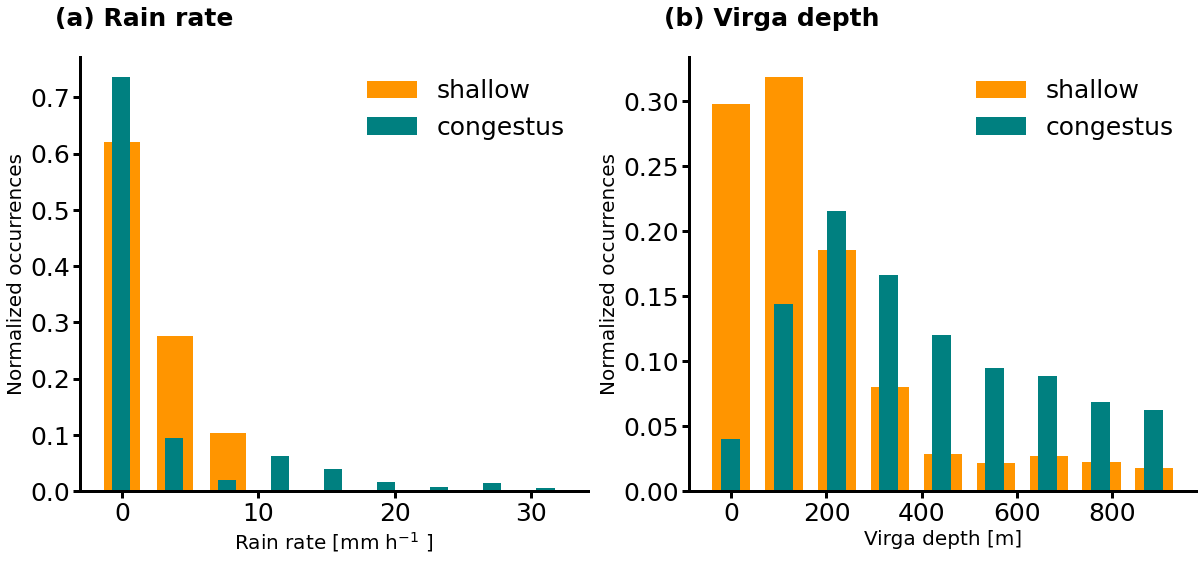

In [19]:

matplotlib.rc('xtick', labelsize=25)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=25) # sets dimension of ticks in the plotsaxs.spines[“top”].set_visible(False)

fig, axs = plt.subplots(1,2, figsize=(20,8))

width_rr = 2.7
axs[0].bar(bins_rr_s[:-1], hist_rr_s, width=width_rr, color=shallow_color, label='shallow')
axs[0].bar([i-0.025*width_rr for i in bins_rr_d[:-1]], hist_rr_d, align='center', width=0.5*width_rr, color=congestus_color, alpha=1., label='congestus')
axs[0].set_xlabel('Rain rate [mm h$^{-1}$ ]', fontsize=20)
#axs[0].set_title('Rain rate for precipitation with shallow/deep clouds', fontsize=20)

width_vd = 80
axs[1].bar(bins_vd_s[:-1], hist_vd_s, width=width_vd, color=shallow_color, label='shallow')
axs[1].bar([i-0.025*width_vd for i in bins_vd_d[:-1]], hist_vd_d, align='center', width=0.5*width_vd, color=congestus_color, alpha=1., label='congestus')
axs[1].set_xlabel('Virga depth [m]', fontsize=20)
#axs[1].set_title(' for shallow/deep clouds', fontsize=20)

for ax, l in zip(axs[:].flatten(), ['(a) Rain rate ',  '(b) Virga depth ']):
    ax.text(-0.05, 1.07, l,  fontweight='black', fontsize=25, transform=ax.transAxes)
for i in range(0,2):
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_linewidth(3)
    axs[i].spines['left'].set_linewidth(3)
    #axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[i].tick_params(which='minor', length=5, width=3)
    axs[i].tick_params(which='major', length=7, width=3)
    axs[i].get_xaxis().tick_bottom()
    axs[i].get_yaxis().tick_left()
    axs[i].set_ylabel('Normalized occurrences', fontsize=20)
    axs[i].legend(frameon = False)

plt.savefig(path_out+'histogram_rain_rate_virga_depth_shallow_deep.png', transparent=True, bbox_inches='tight')